In [1]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cross_validation import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import copy
from typing import List
%matplotlib inline
import matplotlib.pyplot as plt 

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Data = pd.read_csv("network_backup_dataset.csv")
labels = Data.columns
for i, v in enumerate(labels):
    print "labels[" + str(i) + "] => " + v

def convert_OneDimension(label, data):
    
    if label == labels[1]:
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for day, number in zip(days, range(len(days))):
            data = data.replace({'Day of Week': {day : number}})
        return data
    
    elif label == labels[3]:
        work_flow_ids = ['work_flow_0', 'work_flow_1','work_flow_2','work_flow_3', 'work_flow_4']
        for work_flow, number in zip(work_flow_ids, range(len(work_flow_ids))):
            data = data.replace({'Work-Flow-ID' : {work_flow : number}})
        return data
    
    elif label == labels[4]:
        uniqueFiles = ['File_{0}'.format(s) for s in range(len((pd.unique(Data['File Name']))))]
        for file_name, number in zip(uniqueFiles,range(len(uniqueFiles))):
            data = data.replace({'File Name' : {file_name : number}})
        return data      
    else:
        return data

for i in range(len(labels)):
    Data = convert_OneDimension(labels[i], Data)

labels[0] => Week #
labels[1] => Day of Week
labels[2] => Backup Start Time - Hour of Day
labels[3] => Work-Flow-ID
labels[4] => File Name
labels[5] => Size of Backup (GB)
labels[6] => Backup Time (hour)


In [3]:
def get_rmse(target, predict):
    n = len(predict)
    total = sum([(target[i] - predict[i])**2 for i in range(n)])
    return (total / n) ** 0.5

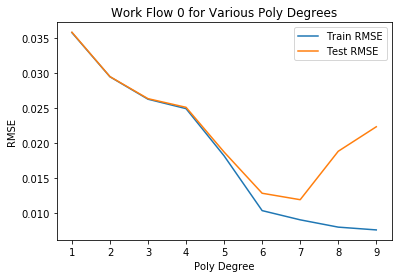

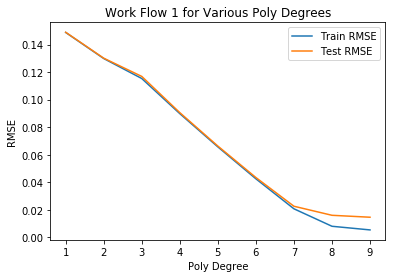

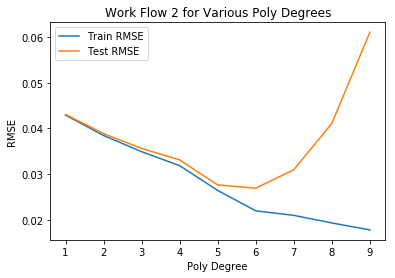

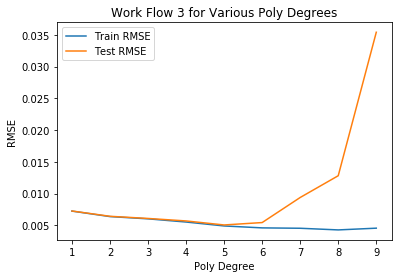

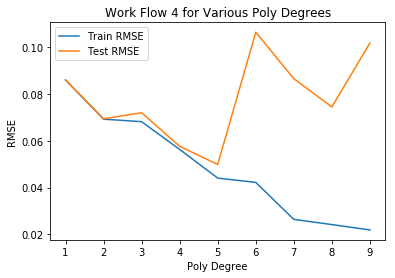

In [4]:
range_of_degree = range(1, 10)
kf = KFold(n_splits = 10)
train_data = copy.deepcopy(Data)
train_data.drop(labels[6],1,inplace = True)
df = pd.DataFrame(train_data)
grouped = df.groupby(['Work-Flow-ID'])
test_rmse_list = []
train_rmse_list = []
for work_flow_data in grouped:
    work_flow_number = list(work_flow_data)[0]
    work_flow = list(work_flow_data)[1]   
    work_flow_train = np.asarray(work_flow)
    
    work_flow_array = work_flow_train[:, :5]
    target_data = work_flow_train[:, 5]
          
    train_mse = [0] * len(range_of_degree)
    test_mse = [0] * len(range_of_degree)
    for train_index, test_index in kf.split(work_flow_array):
        train_sample = work_flow_array[train_index, :]
        train_target = target_data[train_index]

        test_sample = work_flow_array[test_index, :]
        test_target = target_data[test_index]
            
        for i, degree in enumerate(range_of_degree):
            polynomial_features = PolynomialFeatures(degree)
            linear_regression = LinearRegression()
        
            pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
            pipeline.fit(train_sample, train_target)

            train_predicted = pipeline.predict(train_sample)
            test_predicted = pipeline.predict(test_sample)
        
            train_mse[i] += mean_squared_error(train_target, train_predicted)
            test_mse[i] += mean_squared_error(test_target, test_predicted)
    
    train_rmse = map(lambda x: (x / 10) ** 0.5, train_mse)
    test_rmse = map(lambda x: (x / 10) ** 0.5, test_mse)

        
    plt.plot(range_of_degree, train_rmse, label = 'Train RMSE')
    plt.plot(range_of_degree, test_rmse, label = 'Test RMSE')
    title = str(work_flow_number)
    plt.title('Work Flow ' + title + ' for Various Poly Degrees')
    plt.xlabel('Poly Degree')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
